# Misdirection

Some experiments into how gpt2-small behaves when generating false output.

Semantic structure misdirects the model to produce incorrect output. For example,

> They realise John was two years older than Mary. Mary was born before ..."

In [1]:
import torch
from transformer_lens import HookedTransformer

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained model gpt2-small into HookedTransformer


In [241]:
from itertools import permutations, product
import einops
from fancy_einsum import einsum
from IPython.display import HTML
from circuitsvis.attention import attention_heads
from plotly import express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"

def calculate_logit_diff(cache):
    pred_tokens = torch.tensor([
        [model.to_single_token(c) for c in completions] 
        for _, completions in cache.prompts
    ]).to(device)

    resid_directions = cache.model.tokens_to_residual_directions(pred_tokens)
    return resid_directions[:, 0] - resid_directions[:, 1]

def calculate_head_contribution(cache, towards, layer=-1, pos_slice=-1):
    per_head_residual = cache.stack_head_results(
        layer=layer, pos_slice=pos_slice,
    )

    per_head_logit_diffs = einsum(
        "... batch d_model, batch d_model -> ...",
        per_head_residual, towards,
    )

    return einops.rearrange(
        per_head_logit_diffs,
        "(layer head_index) -> layer head_index",
        layer=cache.model.cfg.n_layers,
        head_index=cache.model.cfg.n_heads,
    )

def calculate_attention_patterns(cache, heads):
    patterns = {}
    for head in heads:
        layer = head // cache.model.cfg.n_heads
        label = f'{layer}.{head % cache.model.cfg.n_heads}'
        head_index = head % cache.model.cfg.n_heads
        patterns[label] = cache["attn", layer][0, head_index]
    return patterns

def plot_attention_patterns(patterns):
    return [
        px.imshow(
            pattern.cpu(),
            color_continuous_scale="rdbu",
            color_continuous_midpoint=0.0,
            title=label
        )
        for label, pattern in patterns.items()
    ]

def visualize_attention_patterns(heads, cache, token_labels=None):
    labels, patterns = [], []
    for head in heads:
        layer = head // cache.model.cfg.n_heads
        head_index = head % cache.model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")
        patterns.append(cache["attn", layer][0, head_index])

    patterns = torch.stack(patterns, dim=0)
    if token_labels is None:
        token_labels = [f"Token {i}" for i in range(cache['attn', 0].shape[-1])]

    return attention_heads(
        attention=patterns, tokens=token_labels, attention_head_names=labels
    ).show_code()

def generate_prompts(templates, names):
    return [
        (prompt.format(S, IO), (IO, S))
        for prompt, (S, IO) in product(templates, permutations(names, 2))
    ]

def plot_grid(figs, rows=1, labels=None, title=None, width=1800):
    cols = len(figs) // rows + (len(figs) % rows > 0)
    labels = labels or [f.layout.title.text for f in figs]
    fig = make_subplots(
        rows=rows, cols=cols, 
        subplot_titles=labels,
    )

    for i, f in enumerate(figs):
        fig.add_trace(f.data[0], row=i // cols + 1, col=i % cols + 1)
        fig.update_yaxes(row=i // cols + 1, col=i % cols + 1, autorange="reversed", visible=False)
        fig.update_xaxes(row=i // cols + 1, col=i % cols + 1, visible=False)

    a = figs[0]
    layout = a.layout
    fig.layout.coloraxis = layout.coloraxis
    fig.layout.width = width
    fig.layout.height = ((width // cols) + 100) * rows
    fig.update_coloraxes(showscale=False)
    fig.update_layout(
        title=dict(text=title, font=dict(size=42), automargin=False, yref="paper"),
    )

    return fig

def print_max_logits(cache, component='resid_post', layers=(-1,)):
    layer = -1
    resid_stream = cache[component, layer][0]
    resid_stream = cache.apply_ln_to_stack(resid_stream, layer)
    logits = cache.model.unembed(resid_stream)
    example_prompt = cache.model.to_str_tokens(cache.prompts[0][0])[1:]
    tokens = cache.model.to_tokens([p for p, _ in cache.prompts])
    pred_token = logits[0, -1, :].argmax(-1)
    pred = model.tokenizer.decode(pred_token)
    example_prompt += [pred]
    probs = cache.apply_ln_to_stack(logits, layer)
    token_probs = probs[:, :, tokens]
    fig = px.imshow(
        token_probs[-1, -1, -1, :].unsqueeze(0).cpu(),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
    )

    for x in range(len(example_prompt)):
        fig.add_annotation(x=x, y=0, text=example_prompt[x], showarrow=False, xshift=0, yshift=0, font=dict(size=16, color='white'))

    fig.update_layout(
        width=1200,  # Set the width of the graph
        height=800,  # Set the height of the graph
        xaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
        yaxis=dict(showticklabels=False, showgrid=False, zeroline=False)
    )

    fig.update_coloraxes(showscale=False)
    print(f'{"".join(example_prompt[:-1])} ...{pred[:5]} ({logits[:, -1, :].max():.2f}/{probs[:, -1, :].max():.2f})')
    return fig

Create clean and corrupted prompt datasets where the corrupted prompts contradict the initial context. Each set is run against the model so we have access to clean and corrupted cached activations.

In [72]:
names = (" Mary", " John", " Alice", " Bob")
prompts = generate_prompts(
    [
        "{0} was two years older than{1}. Who was born first?{0} was born before",
        "{0} was two years younger than{1}. Who was born last?{0} was born after",
        "{0} was taller than{1}. Who was taller?{0} was taller than",
        "{0} was shorter than{1}. Who was shorter?{0} was shorter than",
    ],
    names
)

corrupted_prompts = generate_prompts(
    [
        "{0} was two years older than{1}. Who was born first?{1} was born before",
        "{0} was two years younger than{1}. Who was born last?{1} was born after",
        "{0} was taller than{1}. Who was taller?{1} was taller than",
        "{0} was shorter than{1}. Who was shorter?{1} was shorter than",
    ],
    names
)

len(prompts), len(corrupted_prompts), prompts[0], corrupted_prompts[0]

(48,
 48,
 (' Mary was two years older than John. Who was born first? Mary was born before',
  (' John', ' Mary')),
 (' Mary was two years older than John. Who was born first? John was born before',
  (' John', ' Mary')))

In [73]:
_, cache = model.run_with_cache([p[0] for p in prompts])
cache.prompts = prompts

_, corrupted_cache = model.run_with_cache([p[0] for p in corrupted_prompts])
corrupted_cache.prompts = corrupted_prompts

Below prints the tokens against the logit value for each. The generated output is added to the end.

 Mary was two years older than John. Who was born first? Mary was born before ... John (16.81/0.88)


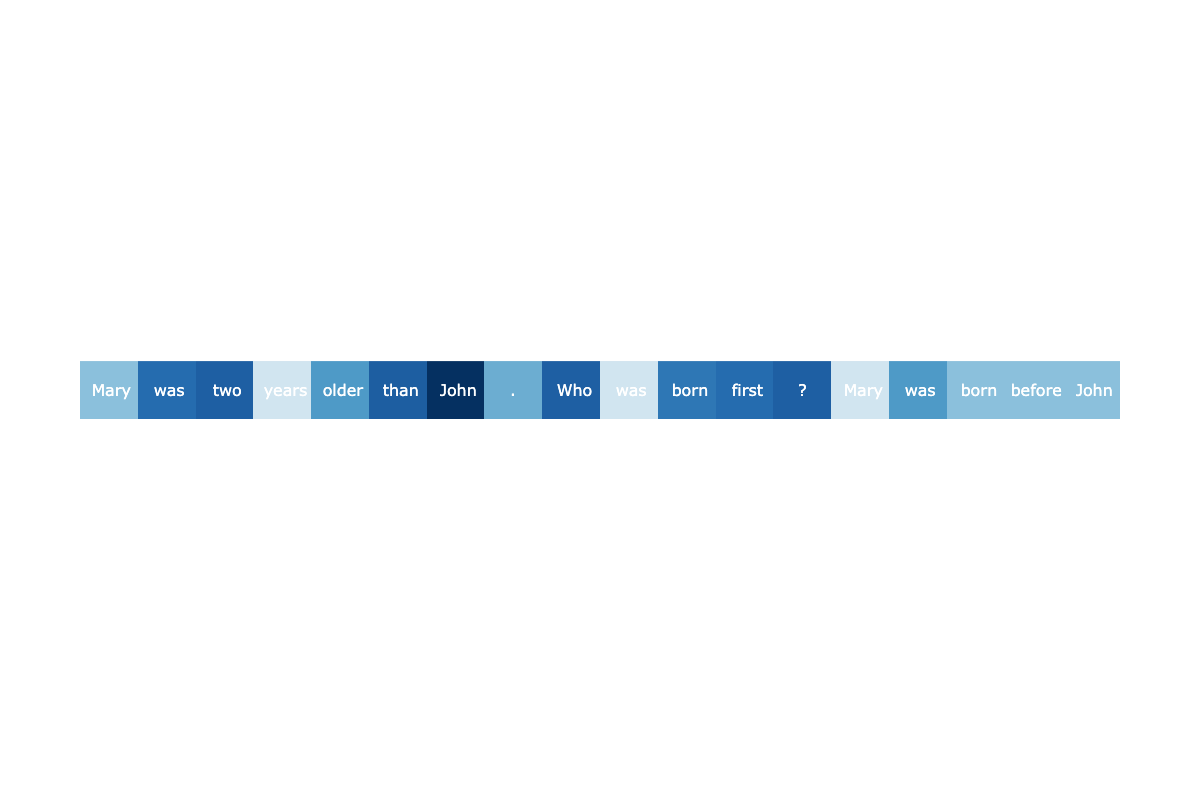

In [164]:
print_max_logits(cache)

 Mary was two years older than John. Who was born first? John was born before ... Mary (17.80/0.96)


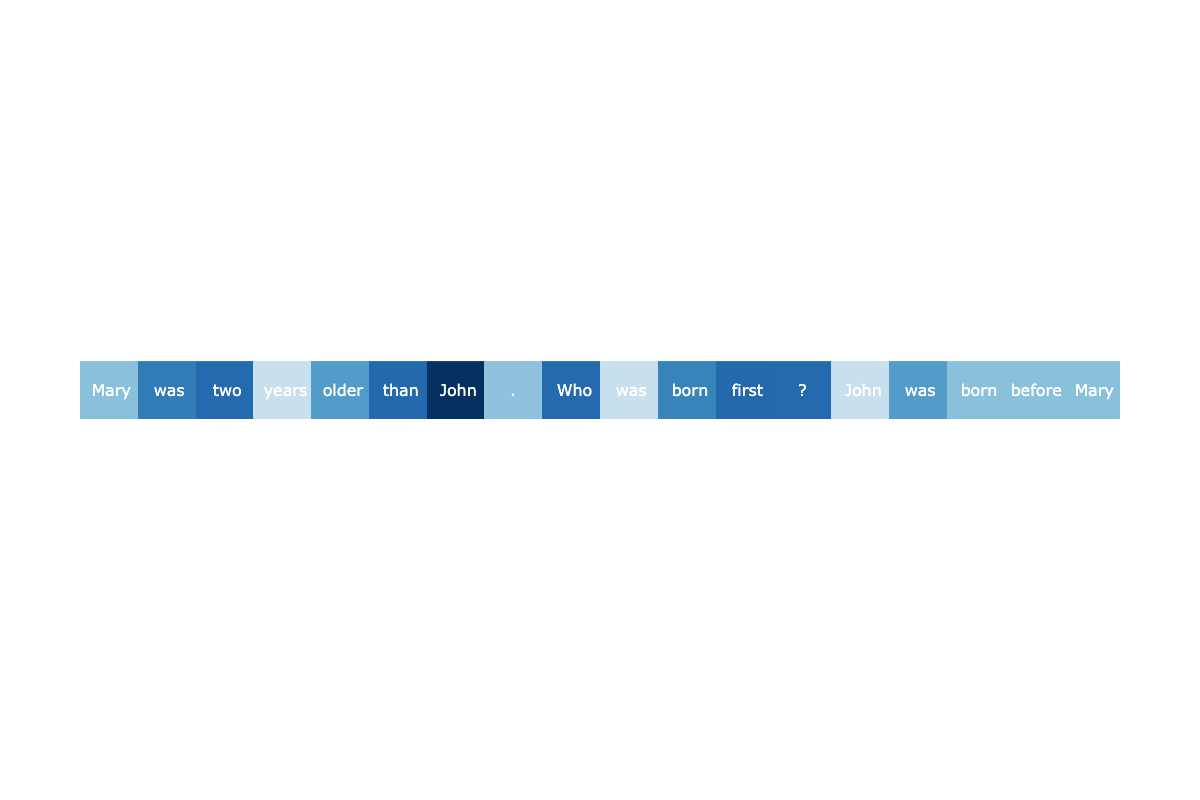

In [165]:
print_max_logits(corrupted_cache)

Interestingly, in the corrupted prompt, we see a slightly increased confidence of the false output (~10% increase).

Looking at the attention head patterns many of the top positive and negative contributors are shared, but there are a few noteable exceptions.

2 1
w: None, h: 580 : 500


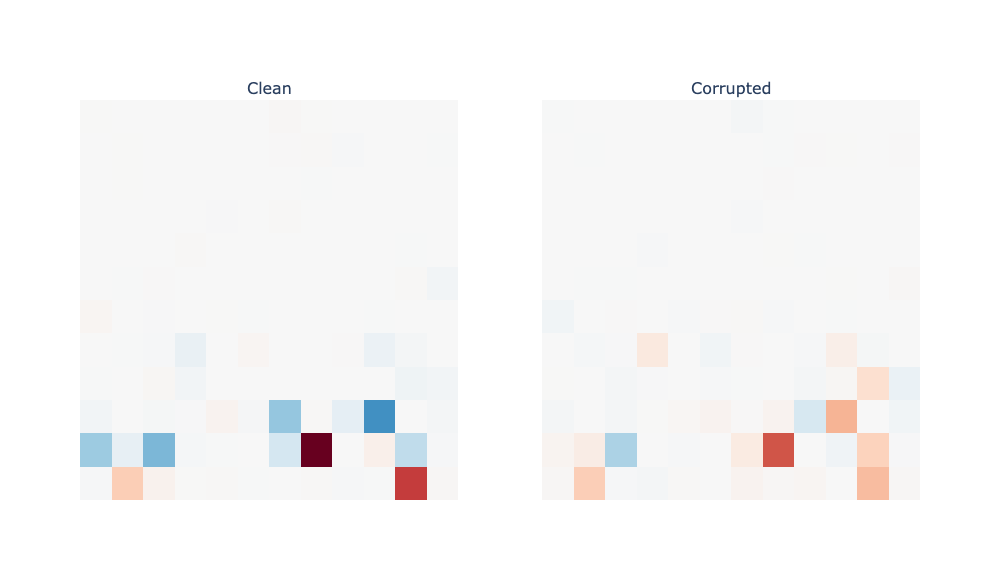

In [169]:
a = px.imshow(
    calculate_head_contribution(cache, calculate_logit_diff(cache)).cpu(),
    labels={"x": "Head", "y": "Layer"},
    color_continuous_midpoint=0.0,
    color_continuous_scale="rdbu",
)

b = px.imshow(
    calculate_head_contribution(corrupted_cache, calculate_logit_diff(corrupted_cache)).cpu(),
    labels={"x": "Head", "y": "Layer"},
    color_continuous_midpoint=0.0,
    color_continuous_scale="rdbu",
)

plot_grid((a, b), titles=["Clean", "Corrupted"])

A couple of the top positive heads (e.g. 10.2, 9.8) are shared, but otherwise the top positive contributors for the clean inputs are the top negative contributors for the corrupted inputs (e.g. 9.9, 10.0, 10.6, etc). Many of these are name-mover heads from the IOI paper.

### Postive head patterns

We can dig into this further by looking at what those attention patterns attend to for each input.

In [88]:
labels, patterns = [], []
for head in range(144):
    layer = head // cache.model.cfg.n_heads
    head_index = head % cache.model.cfg.n_heads
    labels.append(f"L{layer}H{head_index}")
    patterns.append(cache["attn", layer][0, head_index])

patterns = torch.stack(patterns, dim=0)

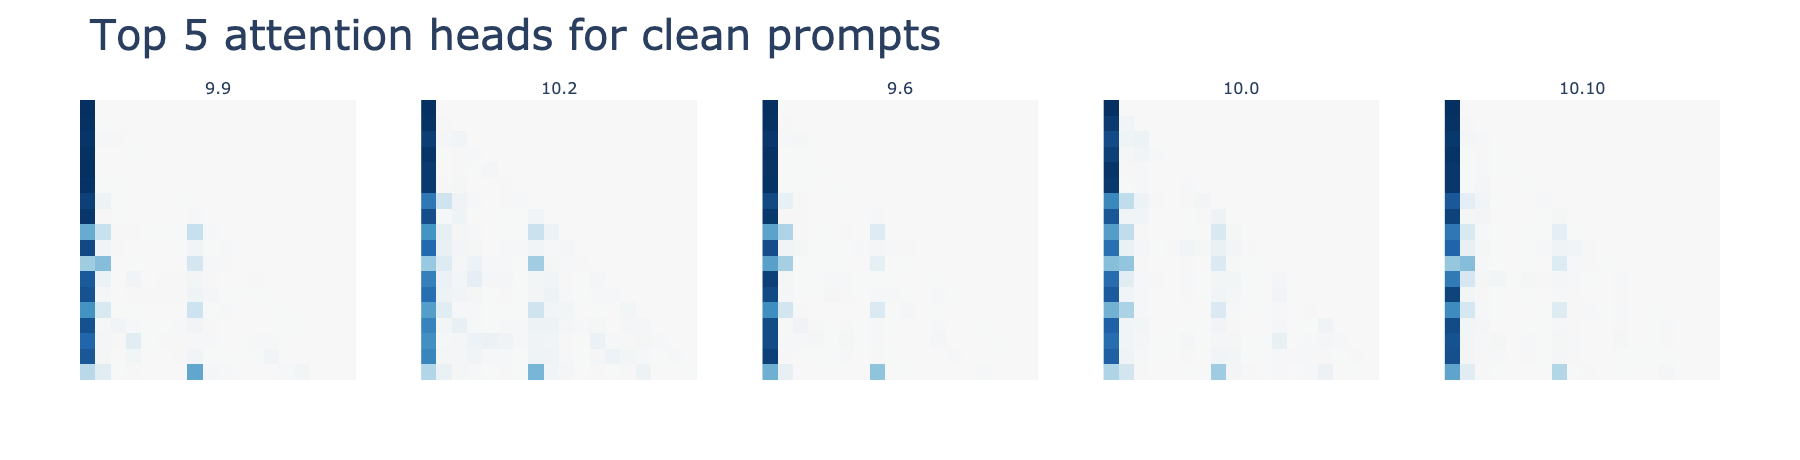

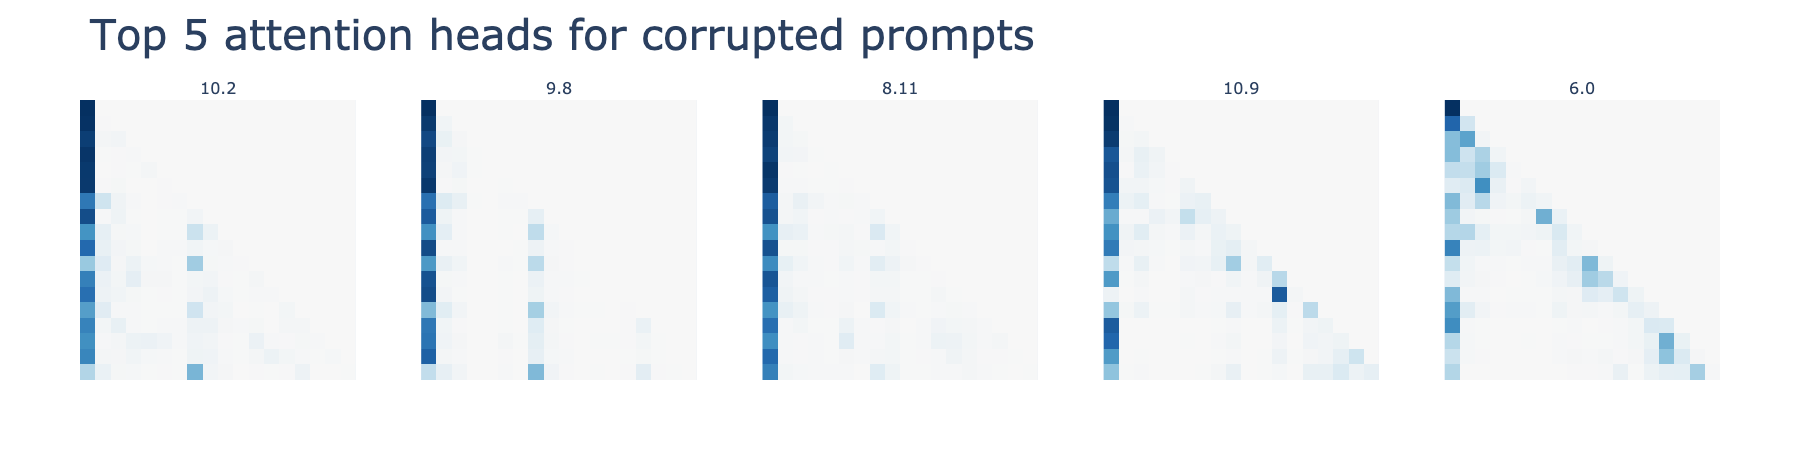

In [225]:
k = 5
logit_diff = calculate_logit_diff(cache)
per_head_logit_diffs = calculate_head_contribution(cache, logit_diff)
heads = torch.topk(per_head_logit_diffs.flatten(), k=k).indices

corrupted_logit_diff = calculate_logit_diff(corrupted_cache)
corrupted_per_head_logit_diffs = calculate_head_contribution(corrupted_cache, corrupted_logit_diff)
corrupted_heads = torch.topk(corrupted_per_head_logit_diffs.flatten(), k=k).indices

patterns = calculate_attention_patterns(heads)
corrupted_patterns = calculate_attention_patterns(corrupted_heads)

figs = plot_attention_patterns(patterns)
corrupted_figs = plot_attention_patterns(corrupted_patterns)

display(plot_grid(figs, title=f'Top {k} attention heads for clean prompts'))
plot_grid(corrupted_figs, title=f'Top {k} attention heads for corrupted prompts')

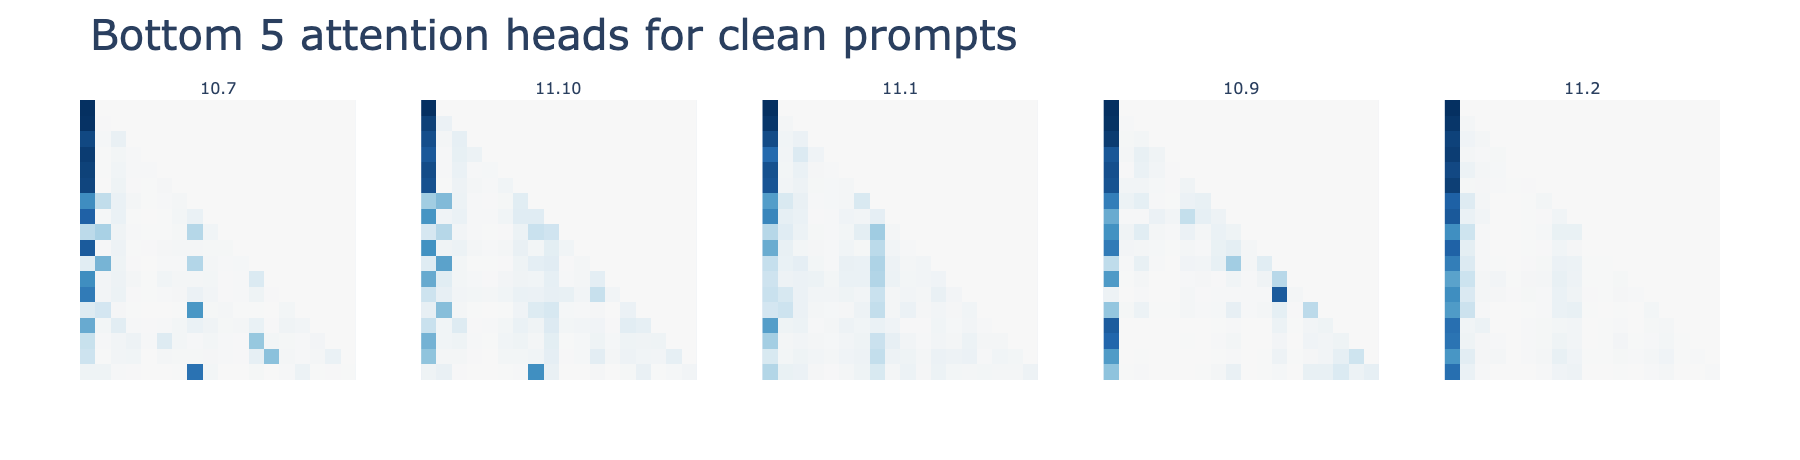

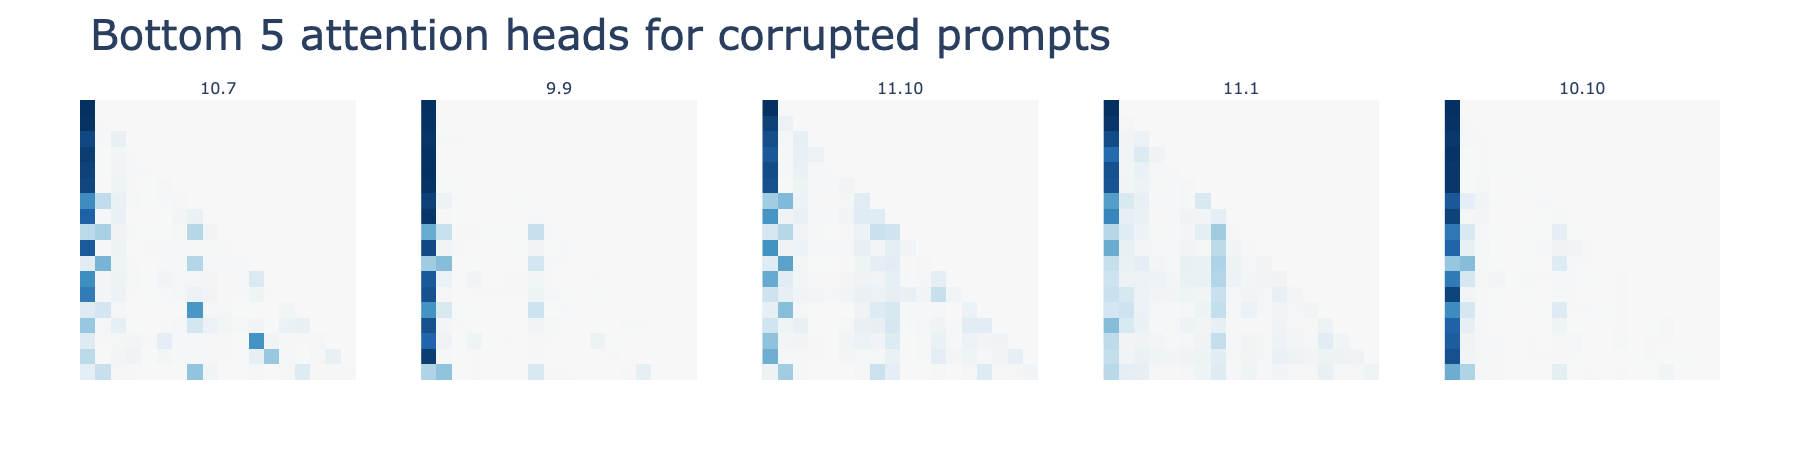

In [246]:
neg_heads = torch.topk(-per_head_logit_diffs.flatten(), k=k).indices
neg_corrupted_heads = torch.topk(-corrupted_per_head_logit_diffs.flatten(), k=k).indices

neg_patterns = calculate_attention_patterns(cache, neg_heads)
neg_corrupted_patterns = calculate_attention_patterns(corrupted_cache, neg_corrupted_heads)

neg_figs = plot_attention_patterns(neg_patterns)
neg_corrupted_figs = plot_attention_patterns(neg_corrupted_patterns)

display(plot_grid(neg_figs, title=f'Bottom {k} attention heads for clean prompts'))
plot_grid(neg_corrupted_figs, title=f'Bottom {k} attention heads for corrupted prompts')

### Interesting early heads

These heads standout when looking at the attention patterns because they show a clear difference between the true and false cases. For true statements the heads attend to the tokens representing the information in the previous sentence (e.g. Mary -> two and was -> years), but for false statements they attend to the period token.

In [257]:
indices = [
    (5, 5),
    (6, 9),
]

indices = [ i * cache.model.cfg.n_heads + j for i, j in indices ]
indices

[65, 81]

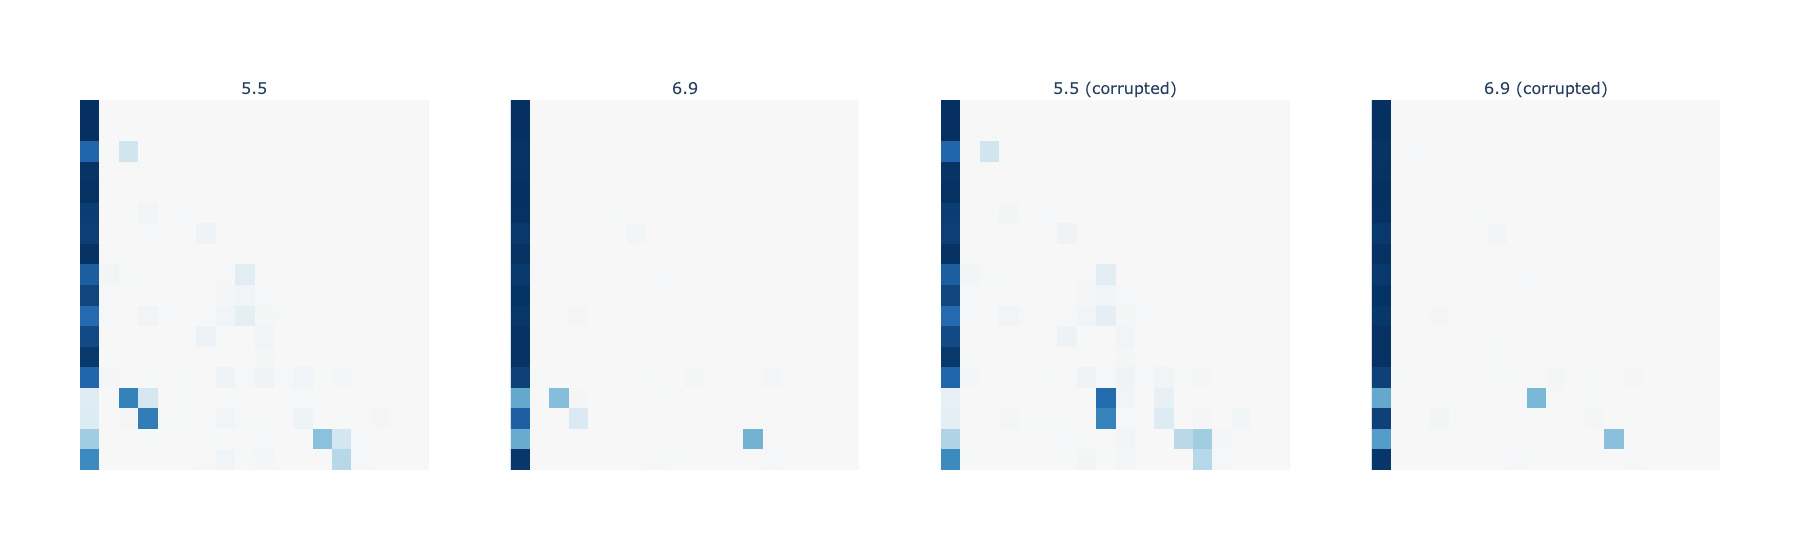

In [273]:
heads = calculate_attention_patterns(cache, indices)
corrupted_heads = calculate_attention_patterns(corrupted_cache, indices)

display(
    plot_grid(
        plot_attention_patterns({
            **heads,
            **{f'{k} (corrupted)': v for k, v in corrupted_heads.items()}
        }),
    )
)

### All heads

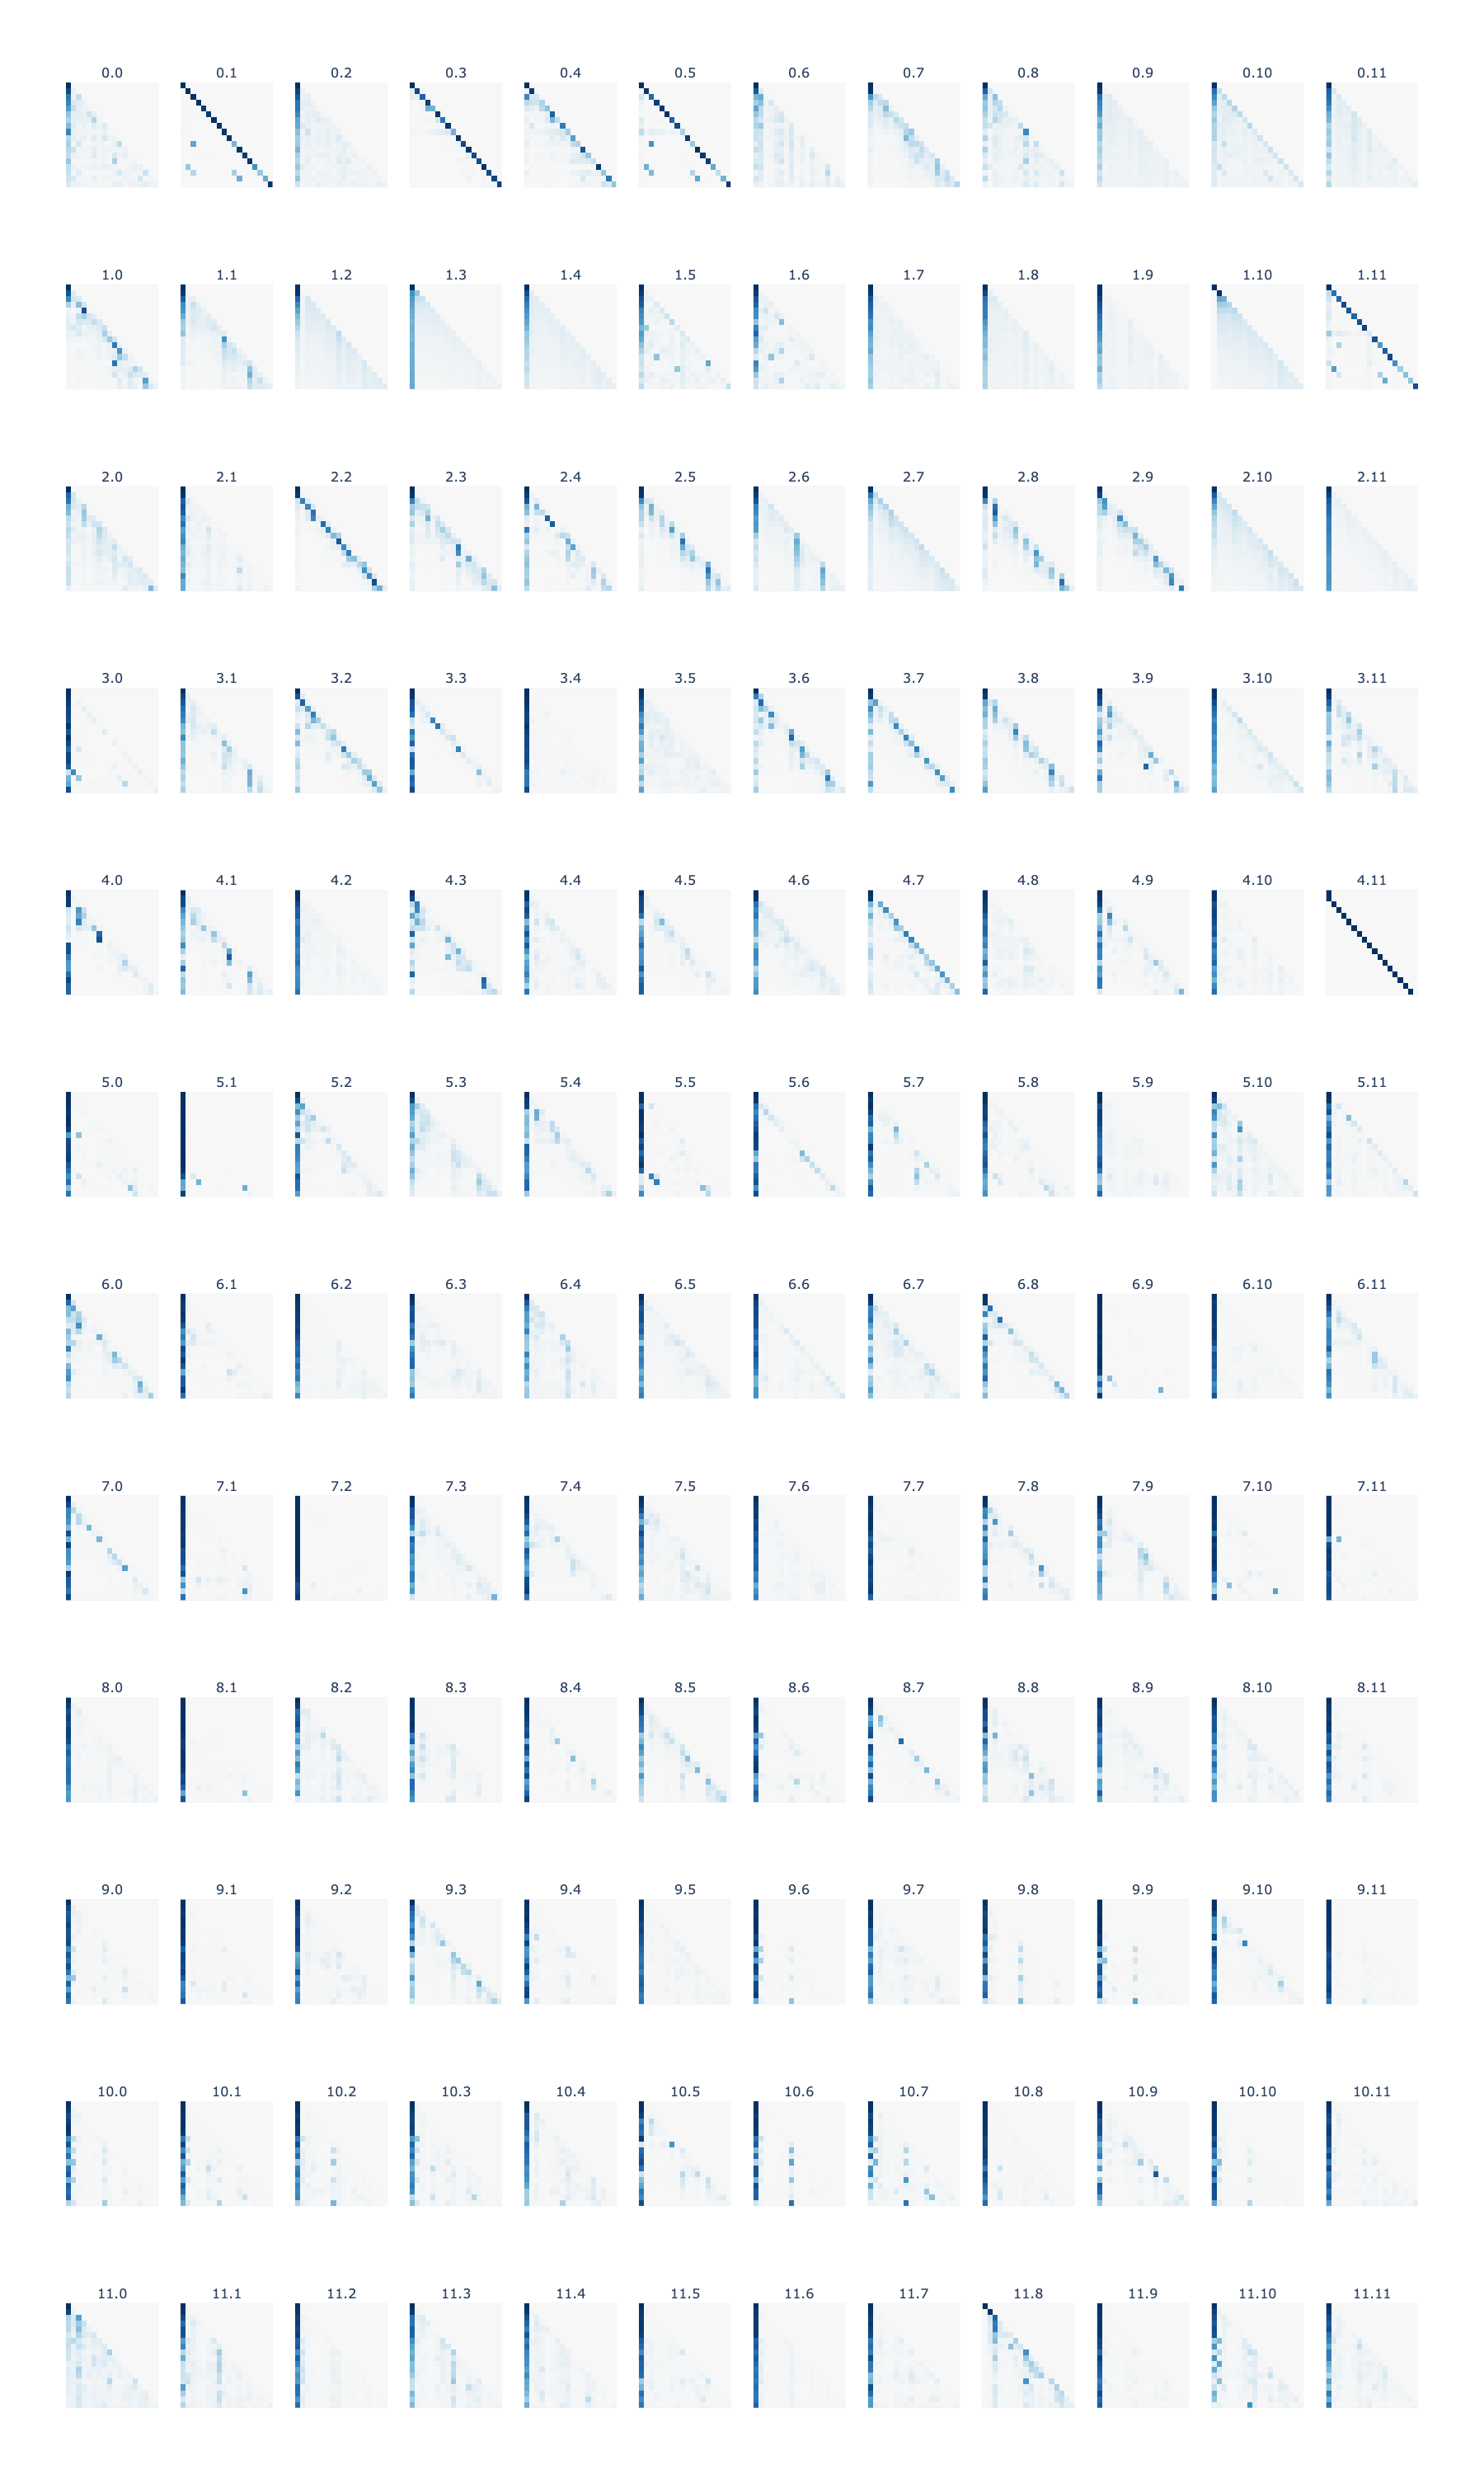

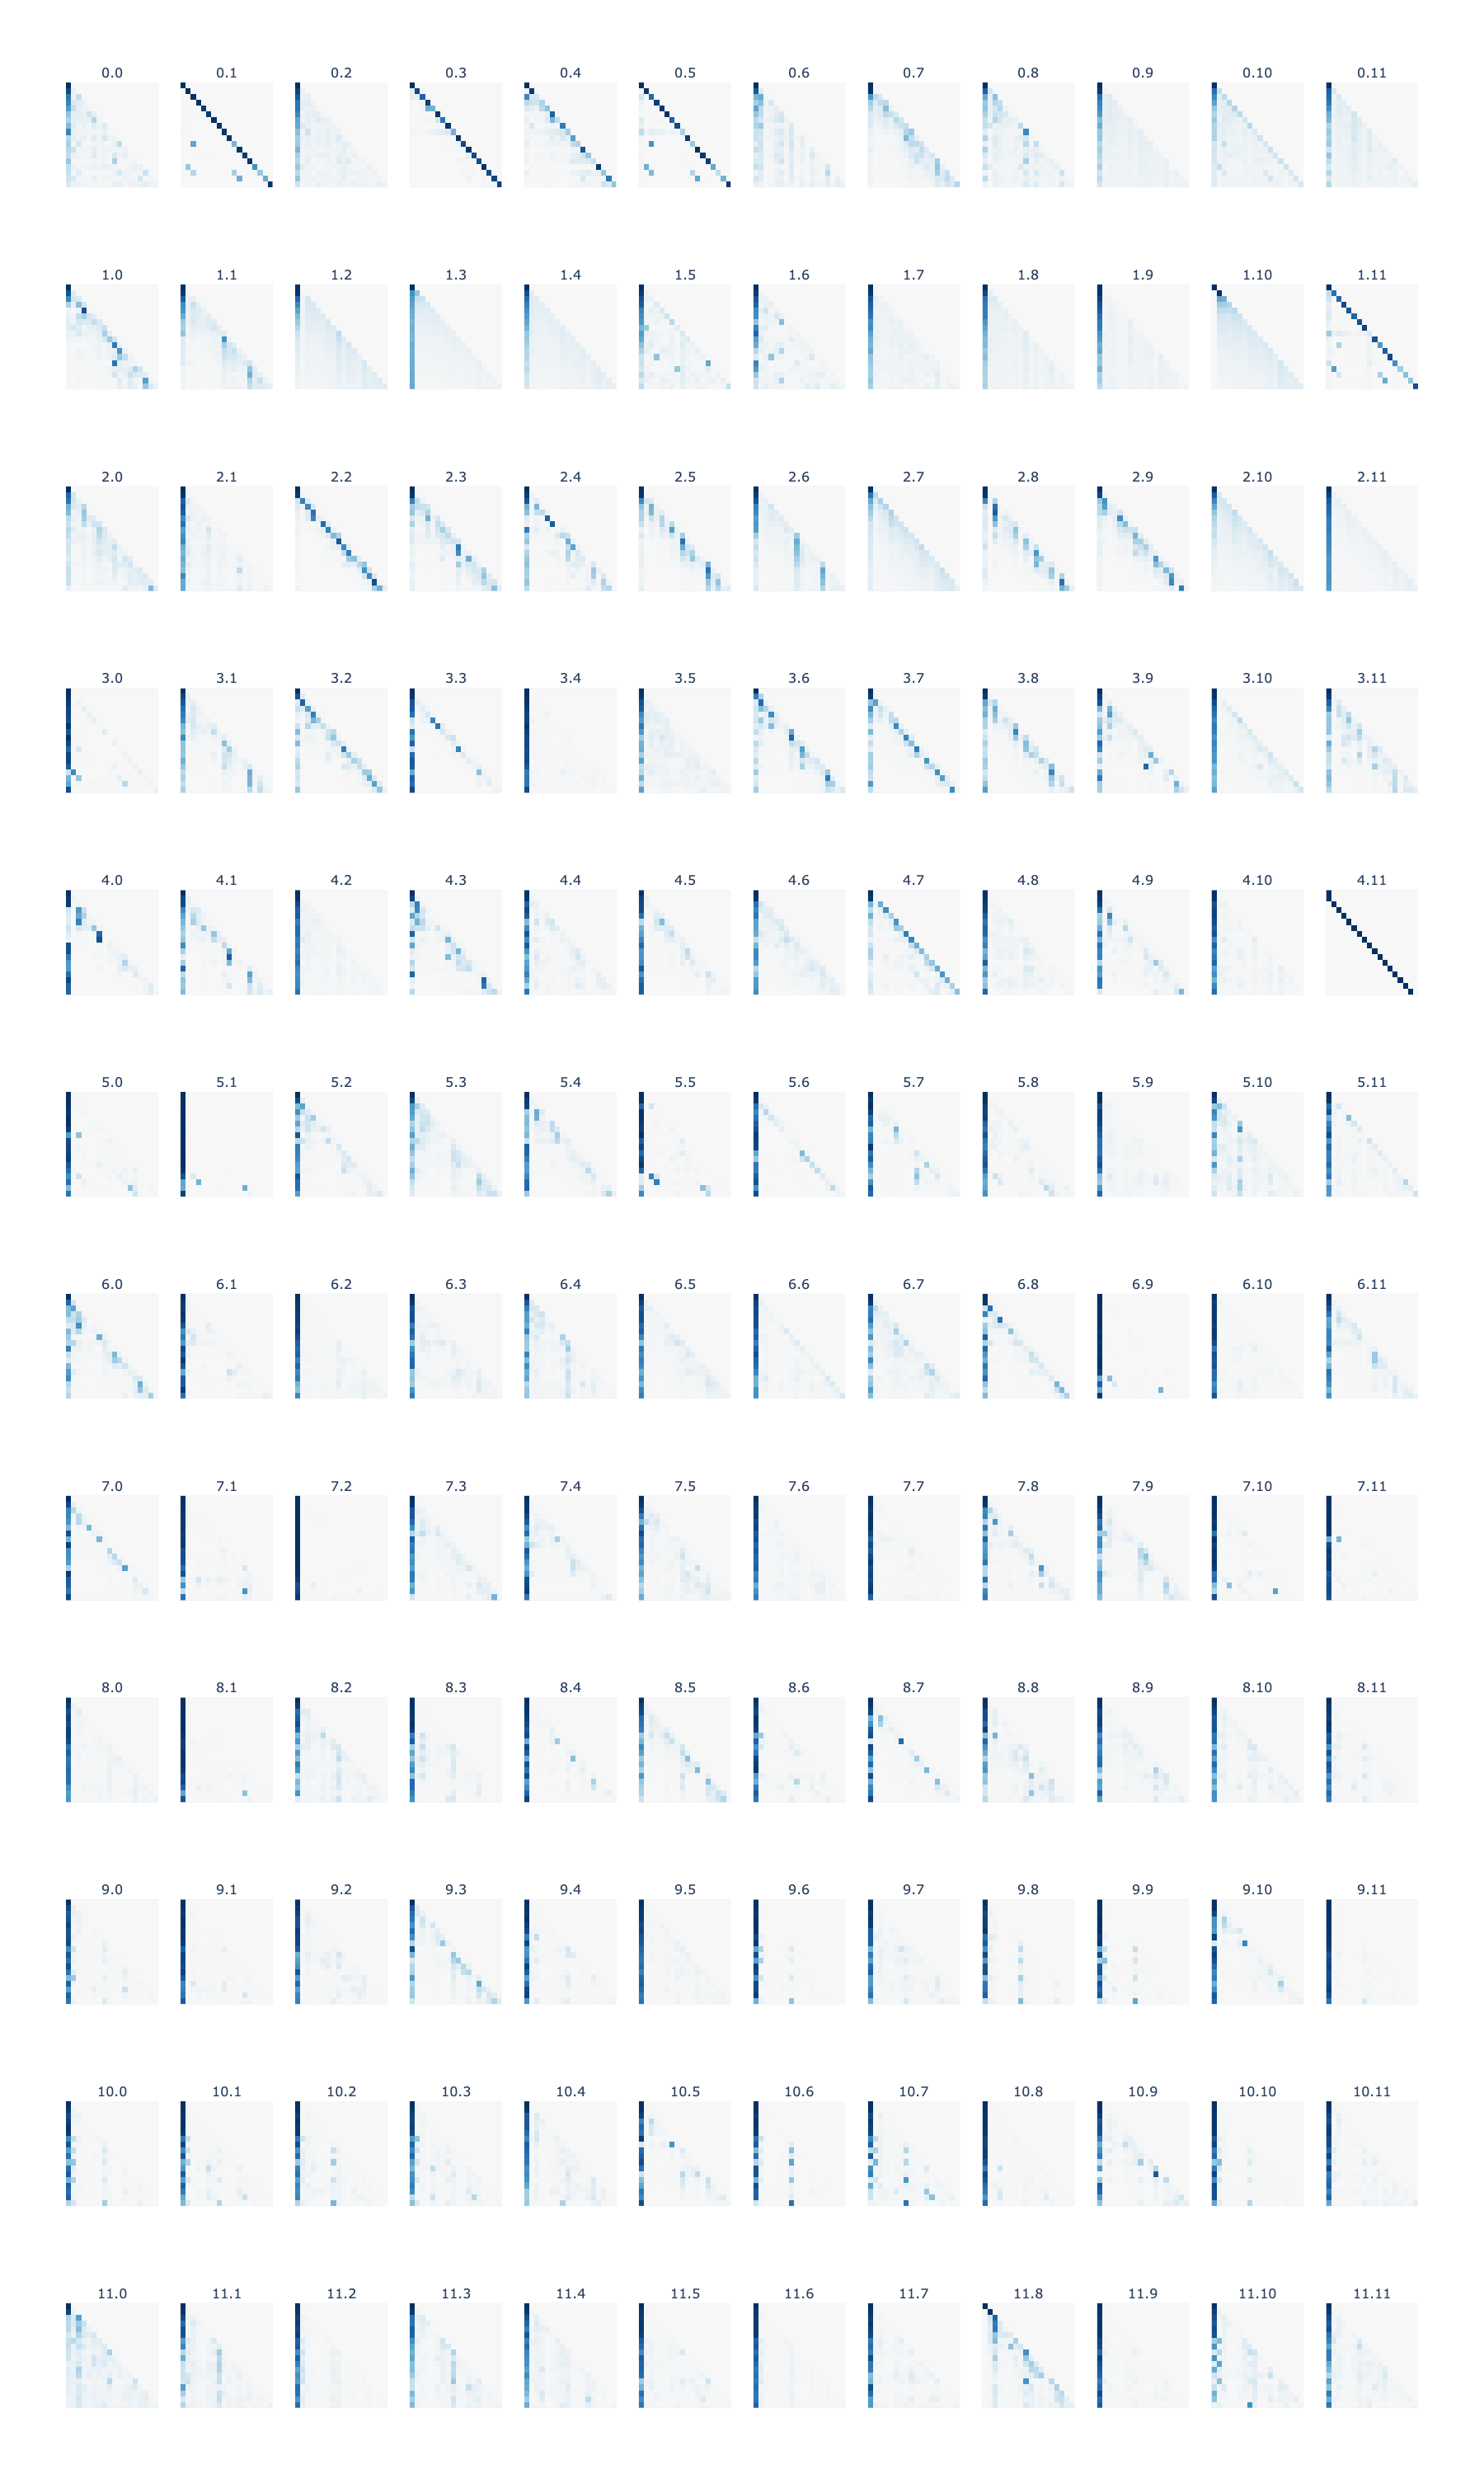

In [272]:
heads = calculate_attention_patterns(cache, range(144))
corrupted_heads = caheads = calculate_attention_patterns(cache, range(144))

display(
    plot_grid(
        plot_attention_patterns(heads),
        rows=12,
    )
)

display(
    plot_grid(
        plot_attention_patterns(corrupted_heads),
        rows=12,
    )
)